In [1]:
#class for managing interactions between model and podcast database.
import pickle
import time
import pandas as pd
import gensim
import numpy as np
import scipy
from sklearn import decomposition,mixture
import sklearn
from matplotlib import pyplot as plt, rcParams
import matplotlib
rcParams.update({'font.size': 15})
from nltk.tokenize import TreebankWordTokenizer,WhitespaceTokenizer
from nltk.corpus import stopwords
import string
import feedparser as fp
import re

class PodcastDB:
    #static class variables
    wp = WhitespaceTokenizer()

    #initialize object
    def __init__(self,fid=None,model=None):
        if(fid is not None):
            self.podcastdb = pickle.load(fid)
            self.w2vs = [v for v in self.podcastdb['w2v']]
            self.npodcast = self.podcastdb.shape[0]
        else:
            raise ValueError('Object constructor must be called with a valid file ID')
            self.podcastdb = None
            self.w2vs = None
            self.npodcast = 0
            
        if(isinstance(model,gensim.models.keyedvectors.Word2VecKeyedVectors)):
            self.model = model
        else:
            raise ValueError('Object constructor must be called with a valid model')
            self.model = None
            
        self.comparator = scipy.spatial.distance.cosine
        self.reclean = re.compile('<.*?>')

            
    #primary method. finds podcasts most similar to some word.
    def search(self,word,n_outputs=5):
        
        word = self._preprocess_input(word)
        
        #ensures that object is properly initialized
        if((self.podcastdb is None) or (self.model is None)):
            raise ClassError('Object not properly initialized.')
            
        if(not word):
            raise ValueError('Input contains no valid words.')
        
        return self.podcastdb.iloc[self.__compare(self._evaluate(word)).argsort()[:n_outputs]]
    

    #primary method. finds podcasts most similar to some word.
    def search_episodes(self,word,n_outputs=3,n_episodes=5,n_most_recent=10):
                
        #find the best podcasts, evaluate input
        pc_match = self.search(word,n_outputs)
        u = self._evaluate(self._preprocess_input(word))
        
        #get the episodes associated with the best podcasts
        #get eps of each matching podcast
        ep_data = [self._get_eps(pc_match.iloc[i]['feedUrl']) for i in range(0,len(pc_match))] 
        #vectorize each episode
        ep_vec = [[self._evaluate(self._preprocess_input(eps['entries'][i]['content'][0]['value'])) 
                   for i in range(0,min([n_most_recent,len(eps['entries'])]))] for eps in ep_data]

        #get relevant ep data
        sorted_eps = [np.array([self.comparator(u,v) for v in ev]).argsort()[:n_outputs] for ev in ep_vec]
        
        #return the data for the best eps
        return pc_match, [[(e['title'],e['content']) for e in eps['entries'][0:min([len(eps['entries']),n_outputs])]]
                          for eps in ep_data]

    #get the most recent n episodes associated with the best matching podcasts
    def _get_eps(self,url):
        try:
            return fp.parse(url)
        except:
            print('Error on ' + url)
            return (url,None)
    
    #apply internal model to a single word. 
    def _evaluate(self,word):
        if(isinstance(word,list)):
            return self.__evaluate_set(word)
        elif(isinstance(word,str)):
            #attempt to get vectorial representation of word.
            try:
                return self.model[word]
            except KeyError as e:
                return np.full([300,],np.nan)
        else:
            raise TypeError()
            
    #apply the model to a set of words and average them. 
    #this is simply ep2vec from other scripts.
    def __evaluate_set(self,words):
        #evaluate each word in 
        n = 0
        a = []
        for w in words:
            #attempt to evaluate vectorial representation of word.
            try:
                v = self.model[w]
                if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                    a.append(v)
                    n += 1
            except KeyError as e:
                pass
        #if nothing was valid, return nan
        if(n==0):
            return np.full([300,], np.nan)
        #return average
        return np.mean(np.array(a),axis=0)
        
    #compares vector 
    def __compare(self,u):
        
        #return distances between vector and all our podcasts.
        return np.array([self.comparator(u,v) for v in self.w2vs])
    
    #This removes non-alphabetical characters and makes everything lower case
    def __clean(self,text):
        return ''.join(c for c in self.remove_html_tags(text.lower()) if c in string.ascii_lowercase+' ')
    
    #this tokenizes intelligently
    @classmethod
    def __tokenize(cls,text):
        #return TreebankWordTokenizer().tokenize(text)
        return cls.wp.tokenize(text)

    #takes out stopwords
    @classmethod
    def __remove_stop_words(cls,tokens):
        return [word for word in tokens if word not in stopwords.words('english')]
            
    def remove_html_tags(self,text):
        return re.sub(self.reclean, '', text)   
    
    #this will clean & tokenize a list of documents.
    def _preprocess_input(self,textinput):
        return self.__remove_stop_words(self.__tokenize(self.__clean(textinput)))
    

In [2]:
#load in podcast df, gensim model, and put it in the database object.

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
modelfname = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(floc+modelfname, binary=True)


In [3]:
podcastfname = 'podcast_df_subset_BIGDATA_1529347011.pkl'
with open(floc+podcastfname,'rb') as fid:
    podcastdb = PodcastDB(fid=fid,model=word2vec)

In [5]:
start_time = time.time()
output = podcastdb.search_episodes('How Anti-Immigration Passion Was Inflamed From the Fringe')
stop_time = time.time()
duration = stop_time - start_time
print(duration)

4.233759164810181


In [139]:
def format_episode_output(output):
    outstr = ''
    for i in range(0,output[0].shape[0]):
        outstr += output[0]['trackName'].iloc[i] + '\n'
        for j in range(0,len(output[1][i])):
            outstr += '\t\t' + output[1][i][j][0] + '\n'
            outstr += '\t\t\t\t' + podcastdb.remove_html_tags(output[1][i][j][1][0].value) + '\n'
    return outstr

print(format_episode_output(output))

LL Decker & Assiciates, Inc.
		Baseball and Temporal Communities
				This podcast illustrates how temporal communities operate to establish rules and standards for member behavior.
		Over My Dead Body!
				2008-07-10: NIMBY-ism and the polarity of voters
Keys To The House
		Republicans Hold Back Blue Wave, But Democrats Avoid Shutouts In California Primary
				California's contentious congressional races in Southern California brought in millions of dollars in campaign spending from national Democratic organizations that previously ignored these districts.
Host Ben Bradford asks political strategists whether the choice to spend big bucks paid off. Experts also talk about the "political chess game" that the parties played in order to succeed under California's "top-two" primary system. And they weigh in on each party&rsquo;s advantages and challenges going into the general election.
Guests:
Christine Mai-Duc Political Reporter LA Times @cmaiduc
Darry Sragow Attorney/Former Democratic Po

In [5]:
#Fit a gaussian mixture model for clustering to see how well topics are separated in vector space.
import numpy as np

n_components=10

#pull out podcast vectors and fit.
X = np.array(podcastdb.w2vs)#training examples
print(X.shape)
gmm = mixture.GaussianMixture(n_components=n_components)
gmm.fit(X)

X_labels = gmm.predict(X)

(31311, 300)


Text(0.5,1,'Clusters of podcast vectors (21.0% variance)')

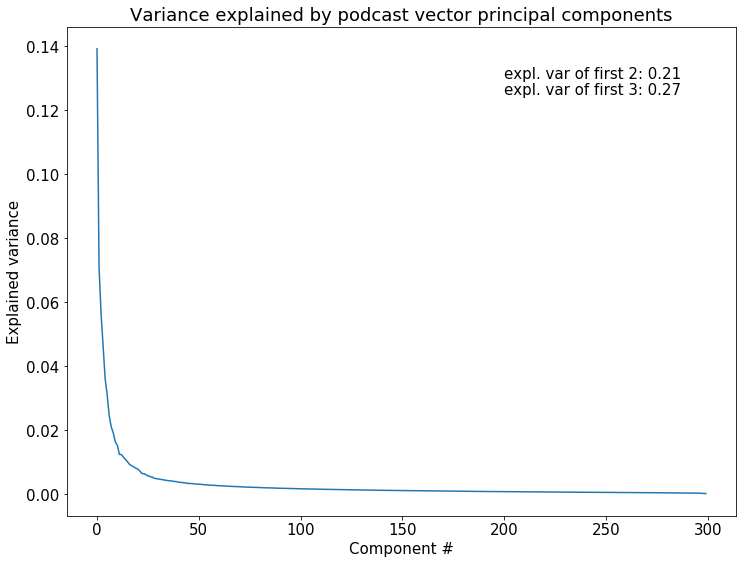

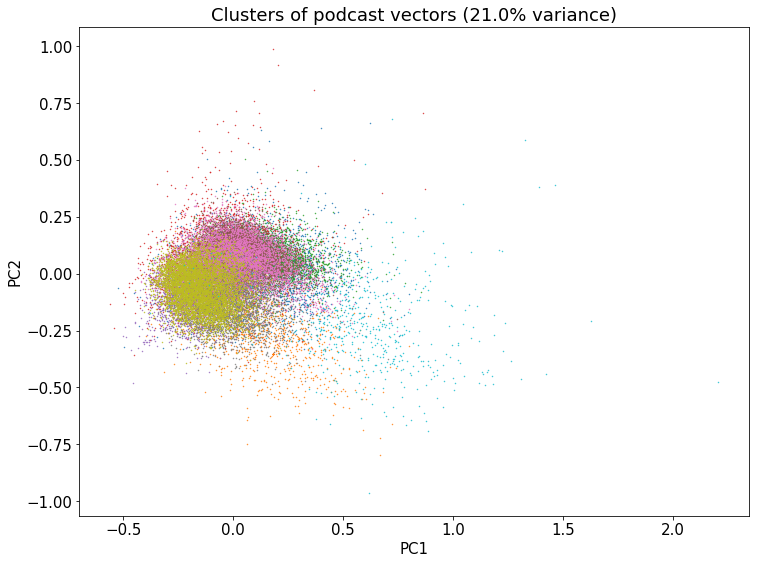

In [7]:
#Perform PCA to examine how explained variance is distributed across principal components. 
from sklearn import decomposition,mixture
import sklearn
from matplotlib import pyplot as plt, rcParams
import matplotlib
rcParams.update({'font.size': 15})

X = np.array(podcastdb.w2vs)
pca = sklearn.decomposition.PCA()
pca.fit(X)

plt.figure(figsize=[12,9])
plt.plot(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel('Component #')
plt.ylabel('Explained variance')
plt.title('Variance explained by podcast vector principal components')
plt.text(200,.13,'expl. var of first 2: %.2f' % sum(pca.explained_variance_ratio_[0:2]))
plt.text(200,.125,'expl. var of first 3: %.2f' % sum(pca.explained_variance_ratio_[0:3]))

#reduce data to first 2 dimensions and plot according to cluster membership. 
ndim = 2
X_reduced = np.matmul(X-np.mean(X, axis=0),pca.components_[0:ndim].T)

cmap = plt.get_cmap('tab10')
plt.figure(figsize=[12,9])
for l in np.unique(X_labels):
    X_thiscluster = X_reduced[X_labels==l,:]
    plt.scatter(X_thiscluster[:,0],X_thiscluster[:,1],s=.2,c=cmap(l))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters of podcast vectors (%.1f%% variance)' % sum(100*pca.explained_variance_ratio_[0:2]))

In [4]:
#Validate model. Try to predict topics using xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

categories = podcastdb.podcastdb['primaryGenreName'].drop_duplicates()


labeler = LabelEncoder()
labeler = labeler.fit(podcastdb.podcastdb['primaryGenreName'])
X = np.array(podcastdb.w2vs)
encoded_labels = labeler.transform(podcastdb.podcastdb['primaryGenreName'])

seed = int(time.time())
test_size = .2
print("seed = %d" % (seed))
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=test_size, random_state=seed)

#train test split
#dfljk;sdal;k

seed = 1529373901


0.58

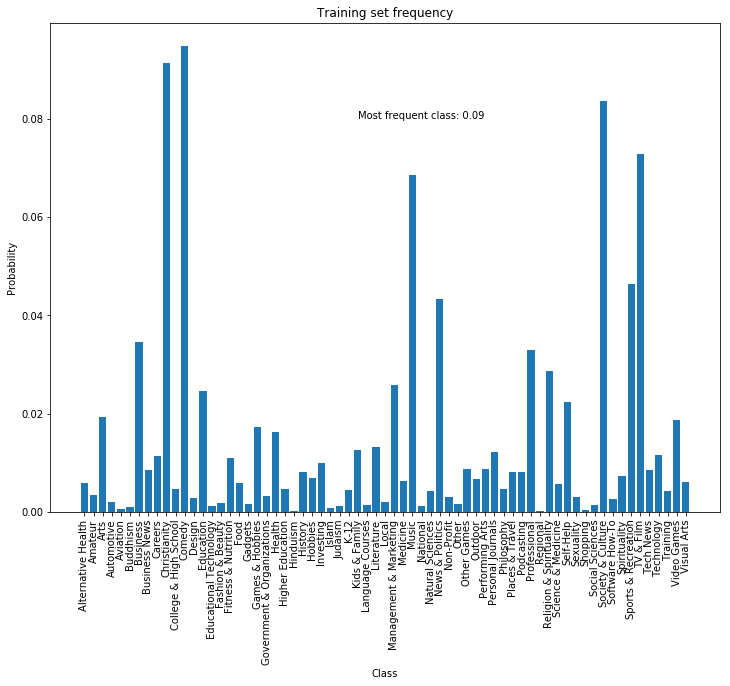

In [30]:
#Examine class distribution in test, train, and overall
import numpy as np


#pull out unique labels and count them
unique, counts = np.unique(podcastdb.podcastdb['primaryGenreName'], return_counts=True)
histdict = dict(zip(unique, counts))
names = list(histdict.keys())
values = list(histdict.values())

        
#compute "chance" frequency in two ways
#method 1: guess most common class always
guess_most_common = np.mean(names[np.argmax(values)]==podcastdb.podcastdb['primaryGenreName'])
#method 2: guess classes randomly proportional to their frequency

fig,ax = plt.subplots(1,1,figsize=[12,9])
ax.bar(names,values/sum(values))
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_title('Training set frequency')
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
ax.text(30,0.08,'Most frequent class: %.2f' % guess_most_common)

In [7]:
from sklearn import linear_model

lreg = linear_model.LogisticRegressionCV(multi_class='multinomial',solver='newton-cg')
lreg.fit(X_train,y_train)


/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [11]:
y_pred = lreg.predict(X_test)
predictions = [round(value) for value in y_pred]

np.mean(predictions==y_test)

array([65, 60, 25, ..., 11,  0, 60])

In [8]:
#gradient boosted trees
import xgboost

model = xgboost.XGBClassifier(nthread=8)
print('Starting fit!')
model.fit(X_train, y_train)
print('Fit done!')
print(model)


Starting fit!
Fit done!
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=8, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
np.mean(predictions==y_test)

/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.473730462620049

In [14]:
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'validation_models_' + str(int(time.time()))
with open(floc+fname,'wb') as fid:
    pickle.dump({'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test,'xgboost_model':model,'linear_model':lreg},fid)